<a href="https://colab.research.google.com/github/asdfasdf0311/Optimal_location_selection/blob/main/02_2_MCLP_%EC%9B%90%EC%A3%BC%EC%8B%9C%EB%82%B4%EC%A0%84%EC%B2%B4_%EC%A7%80%EC%A0%95%EB%A9%B4%EC%A0%9C%EC%99%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 26.4 MB/s eta 0:00:00


In [ ]:
!pip install pandas numpy ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-cloud-datastore 2.19.0 requires protobuf!=3.20.0,!=3.20.1,!=4.2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from ortools.linear_solver import pywraplp
from geopy.distance import geodesic
import folium

In [ ]:
#데이터 경로 설정
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/2024BIGCON/MCLP/mclp_df.csv')

# 지정면 제외

## 전처리

In [ ]:
# '인구수' 열에서 결측치(NaN)가 있는 행 제거
df = df.dropna(subset=['인구수'])
# '인구수'와 '관광객방문수' 열을 int형으로 변환
df['인구수'] = df['인구수'].astype(int)
df['관광객방문수'] = df['관광객방문수'].astype(int)
# '읍면동명'이 '지정면'인 행 삭제
df = df[df['읍면동명'] != '지정면']

## 가중치 적용 및 중요도 계산

In [ ]:
# 가중치 정의
weights = {
    '인구밀집도': 0.5993,
    '유동인구수': 0.1774,
    '관광객방문수': 0.1031,
    '버스승하차': 0.1203
}

# 정규화 함수 정의
def normalize(series):
    min_val = series.min()
    max_val = series.max()
    if max_val != min_val:
        return (series - min_val) / (max_val - min_val)
    else:
        return pd.Series([0.5]*len(series), index=series.index)

# 각 열을 정규화 (0~1 범위로 스케일링)
df['인구밀집도_norm'] = normalize(df['인구밀집도'])
df['총_유동인구수_norm'] = normalize(df['총_유동인구수'])
df['관광객방문수_norm'] = normalize(df['관광객방문수'])
df['승하차수_norm'] = normalize(df['승하차수'])

# 중요도 계산
df['종합중요도'] = (
    weights['인구밀집도'] * df['인구밀집도_norm'] +
    weights['유동인구수'] * df['총_유동인구수_norm'] +
    weights['관광객방문수'] * df['관광객방문수_norm'] +
    weights['버스승하차'] * df['승하차수_norm']
)

# 중요도 기준으로 정렬
df = df.sort_values(by='종합중요도', ascending=False).reset_index(drop=True)

# 중요도 확인
print(df[['버스정류장명', '종합중요도']])

        버스정류장명     종합중요도
0        롯데시네마  0.760914
1      한신2차아파트  0.741921
2      청솔3차아파트  0.740818
3        현진에버빌  0.738735
4         판부농협  0.738239
..         ...       ...
194     섭재마을회관  0.161108
195  반곡관설동주민센터  0.161108
196    삼보골마을회관  0.161094
197    관설동 차고지  0.161094
198        입춘내  0.161094

[199 rows x 2 columns]


## 거리 계산 및 커버리지 매트릭스 생성

In [ ]:
# 커버리지 반경 설정 (단위: 미터)
coverage_radius = 200  # 예: 200미터

# 최소 거리 설정 (커버리지 영역이 겹치지 않도록)
min_distance = 2 * coverage_radius  # 400미터

# 최적화할 시설 수 설정 (추후 최적 개수 찾기)
num_facilities = 22

# 모든 정류장 간 거리 계산
num_stations = len(df)
distance_matrix = np.zeros((num_stations, num_stations))

for i in range(num_stations):
    for j in range(num_stations):
        if i == j:
            distance_matrix[i][j] = 0
        else:
            coord1 = (df.loc[i, '위도'], df.loc[i, '경도'])
            coord2 = (df.loc[j, '위도'], df.loc[j, '경도'])
            distance = geodesic(coord1, coord2).meters
            distance_matrix[i][j] = distance

# 커버리지 매트릭스 생성 (1: 커버, 0: 미커버)
coverage_matrix = (distance_matrix <= coverage_radius).astype(int)

# 겹치는 커버리지 방지: 정류장 간 최소 거리 준수
# 겹칠 수 있는 정류장 쌍 찾기 (거리가 min_distance 미만)
overlap_pairs = []
for i in range(num_stations):
    for j in range(i+1, num_stations):
        if distance_matrix[i][j] < min_distance:
            overlap_pairs.append((i, j))

print(f"Total overlap pairs: {len(overlap_pairs)}")


Total overlap pairs: 434


## MCLP 모델링 및 해결 (커버리지 영역 겹치지 않도록)

In [ ]:
# OR-Tools 선형 프로그래밍 솔버 초기화
solver = pywraplp.Solver.CreateSolver('SCIP')

if not solver:
    raise Exception("Solver not found.")

# 변수: 각 정류장이 선택되었는지 여부 (0 또는 1)
x = [solver.IntVar(0, 1, f'x_{i}') for i in range(num_stations)]

# 목적 함수: 커버되는 수요의 최대화
objective = solver.Objective()
for j in range(num_stations):
    for i in range(num_stations):
        if coverage_matrix[i][j]:
            objective.SetCoefficient(x[i], df.loc[j, '종합중요도'])
objective.SetMaximization()

# 제약 조건 1: 선택할 정류장 수는 num_facilities
solver.Add(solver.Sum(x) == num_facilities)

# 제약 조건 2: 커버리지 영역 겹치지 않도록 최소 거리 유지
for (i, j) in overlap_pairs:
    solver.Add(x[i] + x[j] <= 1)

# 문제 해결
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print(f'Optimal solution found with total coverage: {objective.Value():.4f}')
    selected_stations = []
    for i in range(num_stations):
        if x[i].solution_value() > 0.5:
            selected_stations.append(df.loc[i, '버스정류장명'])
            print(f'선택된 정류장 {i}: {df.loc[i, "버스정류장명"]}')
else:
    print("No optimal solution found.")


Optimal solution found with total coverage: 13.9711
선택된 정류장 0: 롯데시네마
선택된 정류장 4: 판부농협
선택된 정류장 11: 현진에버빌아파트
선택된 정류장 18: 남원주초등학교
선택된 정류장 19: 남원주중학교입구
선택된 정류장 21: 청솔4차아파트
선택된 정류장 23: 원주중학교
선택된 정류장 26: 두산아파트
선택된 정류장 27: 단구동주민센터
선택된 정류장 30: 통일사거리
선택된 정류장 32: KT강원본부
선택된 정류장 33: 늘품사거리
선택된 정류장 39: 성지병원
선택된 정류장 41: 젊음의광장사거리
선택된 정류장 43: 대성현대아파트
선택된 정류장 45: 원주고 동문회관
선택된 정류장 52: 치악예술관
선택된 정류장 57: 치악체육관
선택된 정류장 60: 동보노빌리티정문
선택된 정류장 70: 명륜2동주민센터


## 최적의 정류장 개수 찾기

Bus Stops: 1, Total Coverage: 0.7382
Bus Stops: 2, Total Coverage: 1.4756
Bus Stops: 3, Total Coverage: 2.2101
Bus Stops: 4, Total Coverage: 2.9436
Bus Stops: 5, Total Coverage: 3.6762
Bus Stops: 6, Total Coverage: 4.4087
Bus Stops: 7, Total Coverage: 5.1412
Bus Stops: 8, Total Coverage: 5.8731
Bus Stops: 9, Total Coverage: 6.6047
Bus Stops: 10, Total Coverage: 7.3363
Bus Stops: 11, Total Coverage: 8.0678
Bus Stops: 12, Total Coverage: 8.7852
Bus Stops: 13, Total Coverage: 9.4872
Bus Stops: 14, Total Coverage: 10.1875
Bus Stops: 15, Total Coverage: 10.8842
Bus Stops: 16, Total Coverage: 11.5066
Bus Stops: 17, Total Coverage: 12.1248
Bus Stops: 18, Total Coverage: 12.7405
Bus Stops: 19, Total Coverage: 13.3560
Bus Stops: 20, Total Coverage: 13.9711
Bus Stops: 21, Total Coverage: 14.5786
Bus Stops: 22, Total Coverage: 15.1766
Bus Stops: 23, Total Coverage: 15.5744
Bus Stops: 24, Total Coverage: 15.8960
Bus Stops: 25, Total Coverage: 16.2119
Bus Stops: 26, Total Coverage: 16.5265
Bus Stop

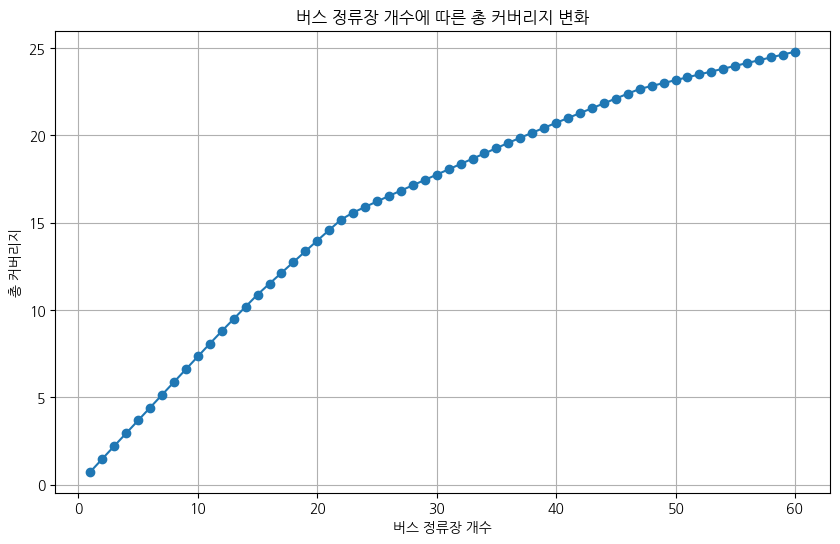

In [ ]:
# 최적의 정류장 개수를 찾기 위한 범위 설정
facility_range = range(1, min(60, num_stations) + 1)  # 1개부터 10개까지 시도 (필요에 따라 조정)
coverage_values = []
selected_stations_list = []

for num in facility_range:
    # OR-Tools 선형 프로그래밍 솔버 초기화
    solver = pywraplp.Solver.CreateSolver('SCIP')

    if not solver:
        raise Exception("Solver not found.")

    # 변수: 각 정류장이 선택되었는지 여부 (0 또는 1)
    x = [solver.IntVar(0, 1, f'x_{i}') for i in range(num_stations)]

    # 목적 함수: 커버되는 수요의 최대화
    objective = solver.Objective()
    for j in range(num_stations):
        for i in range(num_stations):
            if coverage_matrix[i][j]:
                objective.SetCoefficient(x[i], df.loc[j, '종합중요도'])
    objective.SetMaximization()

    # 제약 조건 1: 선택할 정류장 수는 num
    solver.Add(solver.Sum(x) == num)

    # 제약 조건 2: 커버리지 영역 겹치지 않도록 최소 거리 유지
    for (i, j) in overlap_pairs:
        solver.Add(x[i] + x[j] <= 1)

    # 문제 해결
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        coverage = objective.Value()
        coverage_values.append(coverage)
        current_selected_stations = []
        for i in range(num_stations):
            if x[i].solution_value() > 0.5:
                current_selected_stations.append(df.loc[i, '버스정류장명'])
        selected_stations_list.append(current_selected_stations)
        print(f'Bus Stops: {num}, Total Coverage: {coverage:.4f}')
    else:
        coverage_values.append(0)
        selected_stations_list.append([])
        print(f'Bus Stops: {num}, No optimal solution found.')

# 커버리지 변화 시각화
plt.figure(figsize=(10,6))
plt.plot(facility_range, coverage_values, marker='o')
plt.xlabel('버스 정류장 개수')
plt.ylabel('총 커버리지')
plt.title('버스 정류장 개수에 따른 총 커버리지 변화')
plt.grid(True)
plt.show()


### 기울기

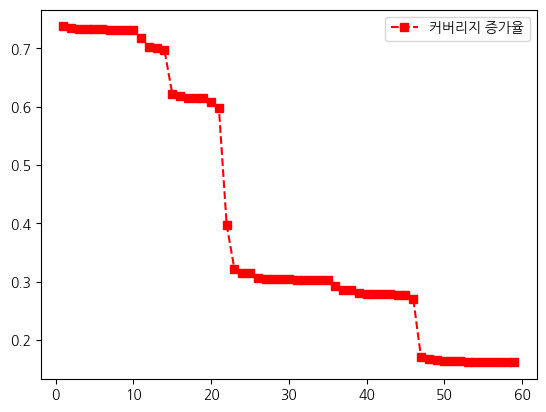

Bus Stops: 1 -> 2, Coverage Increase: 0.7374
Bus Stops: 2 -> 3, Coverage Increase: 0.7344
Bus Stops: 3 -> 4, Coverage Increase: 0.7335
Bus Stops: 4 -> 5, Coverage Increase: 0.7326
Bus Stops: 5 -> 6, Coverage Increase: 0.7325
Bus Stops: 6 -> 7, Coverage Increase: 0.7325
Bus Stops: 7 -> 8, Coverage Increase: 0.7319
Bus Stops: 8 -> 9, Coverage Increase: 0.7317
Bus Stops: 9 -> 10, Coverage Increase: 0.7316
Bus Stops: 10 -> 11, Coverage Increase: 0.7315
Bus Stops: 11 -> 12, Coverage Increase: 0.7175
Bus Stops: 12 -> 13, Coverage Increase: 0.7020
Bus Stops: 13 -> 14, Coverage Increase: 0.7002
Bus Stops: 14 -> 15, Coverage Increase: 0.6967
Bus Stops: 15 -> 16, Coverage Increase: 0.6225
Bus Stops: 16 -> 17, Coverage Increase: 0.6181
Bus Stops: 17 -> 18, Coverage Increase: 0.6157
Bus Stops: 18 -> 19, Coverage Increase: 0.6155
Bus Stops: 19 -> 20, Coverage Increase: 0.6151
Bus Stops: 20 -> 21, Coverage Increase: 0.6075
Bus Stops: 21 -> 22, Coverage Increase: 0.5981
Bus Stops: 22 -> 23, Coverage 

In [ ]:
# 기울기(증가율) 계산
coverage_diffs = np.diff(coverage_values)
slope = coverage_diffs / 1  # 버스 정류장 개수 간 간격이 1이므로 단순히 차이

# 기울기 시각화 (같은 x 축에, shifted x)
plt.plot(facility_range[:-1], coverage_diffs, marker='s', linestyle='--', color='red', label='커버리지 증가율')
plt.legend()
plt.show()

# 기울기 출력
for num, diff in zip(facility_range[:-1], coverage_diffs):
    print(f'Bus Stops: {num} -> {num+1}, Coverage Increase: {diff:.4f}')

## 결과 시각화 (커버리지 영역 포함)

In [ ]:
# 최적의 정류장 개수 선택 (엘보우 지점에 따라 설정)
# 예시로, facility_range 중 최대 커버리지를 제공하는 개수를 선택
# 실제 데이터에서는 엘보우 지점을 시각화한 그래프를 보고 선택하세요
optimal_num_facilities = 22  # 3개로 설정

# 선택된 정류장 목록
selected_stations = selected_stations_list[facility_range.index(optimal_num_facilities)]

print(f'\nOptimal number of bus stops: {optimal_num_facilities}')
print('Selected Bus Stops:')
for station in selected_stations:
    print(f'- {station}')

# 지도 중심 설정 (데이터의 평균 위도와 경도)
center_lat = df['위도'].mean()
center_lon = df['경도'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# 모든 정류장 표시 (파란색 마커)
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=row['버스정류장명']
    ).add_to(m)

# 선택된 정류장 표시 (빨간색 마커) 및 커버리지 반경 표시 (동그라미)
for station in selected_stations:
    row = df[df['버스정류장명'] == station].iloc[0]

    # 선택된 정류장 마커 (빨간색)
#    folium.Marker(
#        location=[row['위도'], row['경도']],
#        popup=f"{row['버스정류장명']}<br>종합중요도: {row['종합중요도']:.4f}",
#        icon=folium.Icon(color='red', icon='info-sign')
#    ).add_to(m)

    # 커버리지 반경 표시 (동그라미)
    folium.Circle(
        location=[row['위도'], row['경도']],
        radius=coverage_radius,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.1
    ).add_to(m)

# 지도 저장 및 표시
m.save('selected_bus_stations.html')
m  # Jupyter Notebook에서 지도를 직접 표시
print("\n선택된 정류장이 표시된 지도가 'selected_bus_stations.html'로 저장되었습니다.")



Optimal number of bus stops: 22
Selected Bus Stops:
- 한신2차아파트
- 판부농협
- 선아아파트
- KT남원주지사
- 성일아파트
- 단구사거리
- 통일아파트
- 두산아파트
- 단구중학교
- 남원주중학교정문
- KT강원본부
- 성지병원
- 원주고등학교
- 상지여중
- 사랑간호데이케어센터
- 도영쇼핑
- 단구2차아파트
- 개운현대아파트
- 치악체육관
- 동보노빌리티입구
- 원주여자중학교
- 청구아파트1단지

선택된 정류장이 표시된 지도가 'selected_bus_stations.html'로 저장되었습니다.


In [ ]:
m